# Text classification / Supervised / SVM TD_IDF

In [301]:
import os
import sys

BASE_DIR = ''
SUBJECT_DIR = os.path.join(BASE_DIR, 'data/subjects') # Collect path to subjects directory

texts = []                                     # list of text samples
labels_index = {}                              # dictionary, label name to numeric id
labels = []                                    # list of label ids
for name in sorted(os.listdir(SUBJECT_DIR)):   # Go through all subdirectories 
    path = os.path.join(SUBJECT_DIR, name)     # Collect each path to subdir
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id          # Collect id to each sub directory/label.
        for fname in sorted(os.listdir(path)):
            if fname.endswith(".txt"):
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    t = t[0:]
                    texts.append(t)            # Append each text from file to text list
                labels.append(label_id)        # Append each label (1-3) to labels list

print(labels_index)

{'_ipynb_checkpoints': 0, 'biology': 1, 'geography': 2, 'physics': 3}


In [302]:
# run nlp_tc.ipynb for LemmaTokenizer
%run utils/nlp_tc.ipynb

In [303]:
import pandas as pd

# Make text list and labels list into pandas DataFrame
data = {}
data['text'] = texts
data['label'] = labels

df = pd.DataFrame(data)

X = df['text']
y = df['label']

In [322]:
show_distribution(y)

1: 1100, 2: 276, 3: 1126


In [305]:
print(X)

0       What are the major functions of male accessory...
1       EXERCISES\n\n1. Bacteria cannot be seen with t...
2       product. The processes include separation and ...
3       EXERCISES\n\n1. Can you list 10 recombinant pr...
4       SUMMARY\n\nBiotechnology has given to humans s...
                              ...                        
2497    backwards. An image is thus a point-to-point\n...
2498    We have derived here the mirror equation, Eq. ...
2499    Example 9.1 Suppose that the lower half of the...
2500    (i) The incident ray, the refracted ray and th...
2501    The refraction of light through the atmosphere...
Name: text, Length: 2502, dtype: object


In [306]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
2497    3
2498    3
2499    3
2500    3
2501    3
Name: label, Length: 2502, dtype: int64


In [307]:
print('Found %s texts.' % len(texts))

Found 2502 texts.


### Make pipeline

In [308]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

MAX_NUM_WORDS = 4000     # Build a vocabulary which only consider the top features of the corpus

# Create our TC pipline with a base of TfIdf and liblinear SVM with a default to ovr (one-vs-the-rest) scheme.
model = Pipeline([
    # Make text to bag-of-words
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(), max_features=MAX_NUM_WORDS)),
    # Transform word count to frequency
    ('tfidf', TfidfTransformer(sublinear_tf=True)),     
    ('clf',LinearSVC(random_state=42, tol=1e-3, max_iter=50))
])

### Train Test Split

In [309]:
from sklearn.model_selection import train_test_split

VALIDATION_SPLIT = 0.21

# Split dataset into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)

### Stratified KFold crossvalidation (best fit for the small balanced Subject corpus)

In [31]:
from sklearn.model_selection import StratifiedKFold

In [294]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#print(skf)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    # select rows
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### KFold crossvalidation (best fit for the big unbalanced Subject corpus)

In [269]:
from sklearn.model_selection import KFold

In [334]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

### Run model

In [335]:
# Fit training set from X (text) and y (labels)
model.fit(X_train, y_train)

# Collect predictions
y_pred = model.predict(X_test)

### Evaluation

In [336]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [337]:
# Save accurate score from evaluation between prediction and test set
acc_model = accuracy_score(y_test, y_pred)
# Save classification report with precision, recall, f1-score
class_report = classification_report(y_test, y_pred)
# Save confusion matrix for model result
confusion_matrix = confusion_matrix(y_test, y_pred)

In [147]:
#print(model.get_params()) 

In [327]:
%run utils/heatmap_tc.ipynb

In [338]:
print(acc_model)

0.996


In [339]:
print(class_report)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       107
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00       111

    accuracy                           1.00       250
   macro avg       1.00      0.99      0.99       250
weighted avg       1.00      1.00      1.00       250



<Figure size 432x288 with 0 Axes>

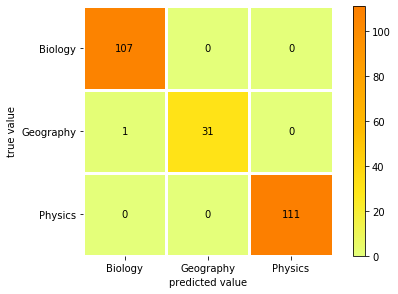

In [340]:
plot_confusion_matrix(confusion_matrix)
plt.show()